## Resume EDA
#### Resumes (300MB)



### Methodology


#### 1 <a href='#setup'>Initial Setup</a>

#### 2. <a href='#eda'>Exploratory Analysis</a>
- 2.0 <a href='#eda'>Cleaning Data</a>    
#### 2. <a href='#future'>Future Extensions</a>



<a id="setup"></a>
## Setup

Let's import the serialized data



In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries
import re
import string
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, json
import unicodedata
from collections import Counter

# NLTK library for stop word removal
from nltk.corpus import stopwords

# SK-learn libraries for learning.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import log_loss

from xml.dom import minidom
from bs4 import BeautifulSoup as BS




In [2]:
import pickle
import sys

sys.setrecursionlimit(20000)
train_xml_ = pickle.load( open( "data/train_1_xml.p", "rb" ) )

In [3]:
train_xml_ = pd.DataFrame(train_xml_)

# shuffle the training data to get rid of implicit order biases
train_data_original = train_xml_.sample(frac = 1)
train_data_original = train_data_original.reset_index()


In [4]:
train_data_original.describe()

,index
count,44397.000000
mean,22198.000000
std,12816.454287
min,0.000000
25%,11099.000000
50%,22198.000000
75%,33297.000000
max,44396.000000


In [5]:
# Lowercase the text
train_data_original['data'] = train_data_original['data'].apply(lambda x: x.lower())

# Attempt to remove css that is encased between {| and |
#train_data_original['data'] = train_data_original['data'].apply(lambda x: re.sub(re.compile('{|.*?|'),'',x))

# Removing line breaks
#train_data_original['data'] = train_data_original['data'].map(lambda x: x.splitlines()).astype(str)

# Remove html tags in <>
#train_data_original['data'] = train_data_original['data'].apply(lambda x: re.sub(re.compile('<.*?>'),'',x))

# Remove content in curly braces {}, which include entities and more css
#train_data_original['data'] = train_data_original['data'].apply(lambda x: re.sub(re.compile('{.*?}'),'',x))

# Remove indicators in HTML
train_data_original['data'] = train_data_original['data'].str.replace('itemprop="worksfor"',' ')
train_data_original['data'] = train_data_original['data'].str.replace('itemtype="http://schema.org/organization"',' ')
train_data_original['data'] = train_data_original['data'].str.replace('itemscope',' ')
train_data_original['data'] = train_data_original['data'].str.replace('present',' ')

train_data_original['plain_data'] = train_data_original['data'].apply(lambda x: re.sub('<[^<]+?>', '', x))



In [6]:
print(train_data_original['data'][0])
print(train_data_original['plain_data'][0])
# print(train_data_original['data'][1])
# print(train_data_original['data'][2])

<div class="vcard single_form-content" id="resume_body">
<div class="last basicinfo-content" id="basic_info_row"><div class="data_display" id="basic_info_cell">
<h1 class="fn " id="resume-contact" itemprop="name">child care worker</h1>
<div id="contact_info_container">
<div class="adr" itemprop="address"  ="" itemtype="http://schema.org/postaladdress"><p class="locality" id="headline_location" itemprop="addresslocality">arcola, tx</p></div>
<div class="separator-hyphen">-</div>
</div>
</div></div>
<div class="section-item workexperience-content">
<div><div class="section_title"><h2>work experience</h2></div></div>
<div class="items-container" id="work-experience-items">
<div class="work-experience-section " id="workexperience-eeynhzewuma12slhbgsw1q"><div class="data_display">
<p class="work_title title">child care worker</p>
<div class="work_company"    =""  >
<span class="bold" itemprop="name">the kensington school</span> <div class="separator-hyphen">-</div> <div class="inline-block"

### Questions to Explore


- How many folks (%) have no previous experience?
- How many jobs do folks have on average?
- What is the average length of resume?

Resume Average Char Length: 5982.0
Resume Median Char Length: 5341.0
Resume Variance Char Length: 3452.7
Resume Min Char Length: 957
Resume Max Char Length: 79399


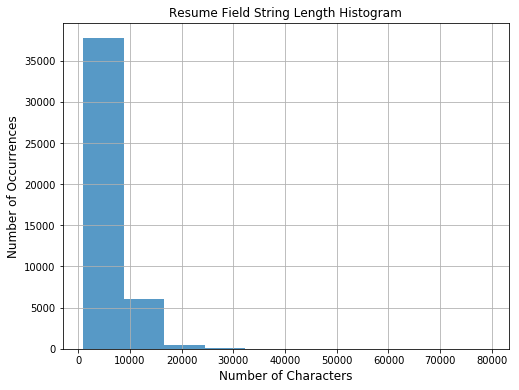

In [7]:
comment_length = train_data_original['data'].str.len()

plt.figure(figsize=(8,6))
plt.title("Resume Field String Length Histogram")
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('Number of Characters', fontsize = 12)
plt.grid(True)

counts, bins, bars = plt.hist(comment_length, alpha = 0.75)

print('Resume Average Char Length: ' + str(round(comment_length.mean(), 1)))
print('Resume Median Char Length: ' + str(round(comment_length.median(), 1)))
print('Resume Variance Char Length: ' + str(round(comment_length.std(), 1)))
print('Resume Min Char Length: ' + str(round(comment_length.min(), 1)))
print('Resume Max Char Length: ' + str(round(comment_length.max(), 1)))


### Predictor Variables EDA

In [7]:
predictors = [];

for i in range(len(train_data_original)):
    predictors.append(train_data_original['predictions'][i])
    
predictors_ = pd.DataFrame(predictors)


In [8]:
predictors_.describe()

,work_company,work_stayed,work_title
count,44397,44397,44397
unique,36752,2,23999
top,Walmart,True,Cashier
freq,321,25435,568


In [10]:
predictors_['work_company'][0]

'The Kensington school'

In [11]:
len(predictors_['work_company'].unique())

36752

In [12]:
# Lowercase the text
predictors_['work_company'] = predictors_['work_company'].apply(lambda x: x.lower())

# Attempt to remove css that is encased between {| and |
predictors_['work_company'] = predictors_['work_company'].apply(lambda x: re.sub(re.compile('{|.*?|'),'',x))

# Removing line breaks
predictors_['work_company'] = predictors_['work_company'].map(lambda x: x.splitlines()).astype(str)

# Remove html tags in <>
predictors_['work_company'] = predictors_['work_company'].apply(lambda x: re.sub(re.compile('<.*?>'),'',x))

# Remove content in curly braces {}, which include entities and more css
predictors_['work_company'] = predictors_['work_company'].apply(lambda x: re.sub(re.compile('{.*?}'),'',x))

# Remove punctuation
predictors_['work_company'] = predictors_['work_company'].str.replace('[^\w\s]','')

# Remove Special Characters
predictors_['work_company'] = predictors_['work_company'].str.replace('[^a-zA-Z ]',' ')

In [13]:
print(len(predictors_['work_company'].unique()))
print(predictors_['work_title'][0])
print(len(predictors_['work_title'].unique()))

35411
Drive Test Engineer
23999


In [14]:
# Lowercase the text

predictors_['work_title'] = predictors_['work_title'].apply(lambda x: x.lower())
predictors_['work_title'] = predictors_['work_title'].str.replace('[/]',' ')

# Attempt to remove css that is encased between {| and |
predictors_['work_title'] = predictors_['work_title'].apply(lambda x: re.sub(re.compile('{|.*?|'),'',x))

# Removing line breaks
predictors_['work_title'] = predictors_['work_title'].map(lambda x: x.splitlines()).astype(str)

# Remove html tags in <>
predictors_['work_title'] = predictors_['work_title'].apply(lambda x: re.sub(re.compile('<.*?>'),'',x))

# Remove content in curly braces {}, which include entities and more css
predictors_['work_title'] = predictors_['work_title'].apply(lambda x: re.sub(re.compile('{.*?}'),'',x))

# Remove punctuation
predictors_['work_title'] = predictors_['work_title'].str.replace('[^\w\s]','')

# Remove Special Characters
predictors_['work_title'] = predictors_['work_title'].str.replace('[^a-zA-Z ]',' ')

In [15]:
print(len(predictors_['work_title'].unique()))
print(predictors_['work_title'][4])
print(predictors_['work_stayed'][0])

22638
consumer loan underwriter
False


### Potential Interesting Features

- whether or not you're going to stay at the same job
- whether you're going into a different job function
- whether you're going to stay at the same company
- whether you're going get promoted?

- level of candidate
- classification of candidate
- diversity?

- skills overlap between current and last job


In [9]:
len_ = int(len(train_data_original)/4)
print(len_)
train_data_ = train_data_original[len_:]
test_data_ = train_data_original[:len_]

predictors_train_ = predictors_[len_:]
predictors_test = predictors_[:len_]

model_results = []


11099


In [11]:
vectorizer_train = TfidfVectorizer(sublinear_tf = True, lowercase = True)
train_fit = vectorizer_train.fit(train_data_['data'])
train_transformed = vectorizer_train.transform(train_data_['data'])
dev_transformed = vectorizer_train.transform(test_data_['data'])
logis_regression = LogisticRegression()
logis_regression.fit(train_transformed, predictors_train_['work_stayed'].astype(int))
pred = logis_regression.predict_proba(dev_transformed)
f1score_logis = logis_regression.score(dev_transformed, predictors_test['work_stayed'].astype(int)) 
accuracy = round(f1score_logis, 6)
log_loss_ = round(log_loss(predictors_test['work_stayed'].astype(int), pred), 6)

model_results.append({"accuracy" : accuracy, "name" : "TFIDF HTML - Predict Stay at Job", "log_loss": log_loss_})


In [12]:
print("Accuracy: " + str(accuracy))
print("Log Loss: " + str(log_loss_))

Accuracy: 0.756735
Log Loss: 0.520343


In [13]:
vectorizer_train_plain = TfidfVectorizer(sublinear_tf = True, lowercase = True)
train_fit_plain = vectorizer_train_plain.fit(train_data_['plain_data'])
train_transformed_plain = vectorizer_train_plain.transform(train_data_['plain_data'])
dev_transformed_plain = vectorizer_train_plain.transform(test_data_['plain_data'])

logis_regression_plain = LogisticRegression()
logis_regression_plain.fit(train_transformed_plain, predictors_train_['work_stayed'].astype(int))
pred_plain = logis_regression_plain.predict_proba(dev_transformed_plain)

f1score_logis = logis_regression_plain.score(dev_transformed_plain, predictors_test['work_stayed'].astype(int))

accuracy = round(f1score_logis, 6)
log_loss_ = round(log_loss(predictors_test['work_stayed'].astype(int), pred_plain), 6)

model_results.append({"accuracy" : accuracy, "name" : "TFIDF Plain Text - Predict Stay at Job", "log_loss": log_loss_})


In [14]:
print("Accuracy: " + str(accuracy))
print("Log Loss: " + str(log_loss_))

Accuracy: 0.650149
Log Loss: 0.623826


In [15]:
model_results

[{'accuracy': 0.756735,
  'name': 'TFIDF HTML - Predict Stay at Job',
  'log_loss': 0.520343},
 {'accuracy': 0.650149,
  'name': 'TFIDF Plain Text - Predict Stay at Job',
  'log_loss': 0.623826}]

In [16]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

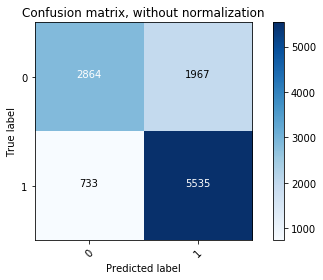

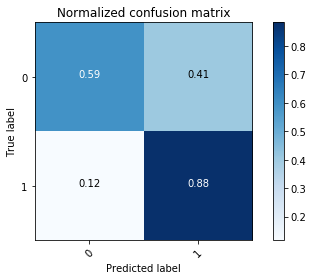

In [17]:
correct_values = predictors_test['work_stayed'].astype(int)
logis_regression_pred = logis_regression.predict(dev_transformed) 

confusion_mat = confusion_matrix(correct_values, logis_regression_pred)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_mat, classes=[0,1], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_mat, classes=[0,1], normalize=True, title='Normalized confusion matrix')

plt.show()


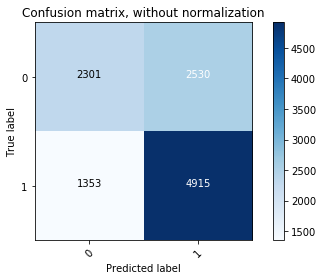

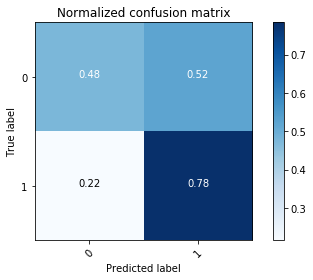

In [18]:
correct_values = predictors_test['work_stayed'].astype(int)
logis_regression_pred = logis_regression_plain.predict(dev_transformed_plain) 

confusion_mat = confusion_matrix(correct_values, logis_regression_pred)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_mat, classes=[0,1], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_mat, classes=[0,1], normalize=True, title='Normalized confusion matrix')

plt.show()


In [19]:
# Print some examples of our vocabulary

def construct_columns_for_top_vocab(vectorizer_train, logis_regression):
    
    # Initialize empty helper vectors and get feature names
    feature_names = vectorizer_train.get_feature_names()
    num_top_features = 10
    all_indices = []
    all_indices_labels = []
    all_indices_values = []
    all_indices_values_with_labels = {}
    
    # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
    indices = (-logis_regression.coef_[0]).argsort()[:num_top_features]
    all_indices.extend(indices)
            
    # Getting all the indices and then adding the feature names for each category
    for i, value in enumerate(all_indices):
        all_indices_labels.append(feature_names[value])
        all_indices_values.append([])
        all_indices_values[i].append(round(logis_regression.coef_[0][value], 3))
        all_indices_values_with_labels[feature_names[value]] = all_indices_values[i]
        
    return all_indices_values_with_labels


showValues = construct_columns_for_top_vocab(vectorizer_train, logis_regression)
df = pd.DataFrame.from_dict(showValues, orient='index')
display(df)

showValues = construct_columns_for_top_vocab(vectorizer_train_plain, logis_regression_plain)
df = pd.DataFrame.from_dict(showValues, orient='index')
display(df)

,0
name,28.135
itemprop,13.673
addresslocality,13.519
postaladdress,13.519
address,13.318
schema,7.628
itemtype,7.622
org,7.606
http,7.462
2016,7.039


,0
2016,6.603
currently,3.473
2015,3.261
manage,3.070
fresno,2.616
lead,2.425
are,2.407
current,2.314
lafayette,2.289
have,2.179


In [48]:


multinomial = MultinomialNB()
multinomial.fit(train_transformed, predictors_train_['work_stayed'].astype(int))
f1score_multi = multinomial.score(dev_transformed, predictors_test['work_stayed'].astype(int)) 

pred_multi = multinomial.predict_proba(dev_transformed)

accuracy = round(f1score_multi, 6)
log_loss_ = round(log_loss(predictors_test['work_stayed'].astype(int), pred_multi), 6)

print("Accuracy: " + str(accuracy))
print("Log Loss: " + str(log_loss_))
model_results.append({"accuracy" : accuracy, "name" : "TFIDF HTML NB - Predict Stay at Job", "log_loss": log_loss_})


Accuracy: 0.571538
Log Loss: 1.20385


In [49]:
multinomial_plain = MultinomialNB()
multinomial_plain.fit(train_transformed_plain, predictors_train_['work_stayed'].astype(int))
f1score_multi = multinomial_plain.score(dev_transformed_plain, predictors_test['work_stayed'].astype(int)) 

pred_plain_multi = multinomial_plain.predict_proba(dev_transformed_plain)

accuracy = round(f1score_multi, 6)
log_loss_ = round(log_loss(predictors_test['work_stayed'].astype(int), pred_plain_multi), 6)

print("Accuracy: " + str(accuracy))
print("Log Loss: " + str(log_loss_))
model_results.append({"accuracy" : accuracy, "name" : "TFIDF Plain NB - Predict Stay at Job", "log_loss": log_loss_})


Accuracy: 0.583206
Log Loss: 0.900991


In [50]:
showValues = construct_columns_for_top_vocab(vectorizer_train, multinomial)
df = pd.DataFrame.from_dict(showValues, orient='index')
display(df)


,0
div,-6.103
class,-6.179
span,-6.459
id,-6.472
itemprop,-6.585
br,-6.628
section,-6.667
and,-6.687
data_display,-6.732
to,-6.735


In [51]:
showValues = construct_columns_for_top_vocab(vectorizer_train_plain, multinomial_plain)
df = pd.DataFrame.from_dict(showValues, orient='index')
display(df)

,0
and,-6.088
to,-6.113
in,-6.396
of,-6.412
the,-6.428
for,-6.506
with,-6.616
work,-6.637
skills,-6.770
customer,-6.791


In [15]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion


In [16]:
# Loading list of stopwords from nltk corpus
stop_words = stopwords.words('english')

# Helper function for finding the percent of stop words in the message
def contains_stop_words(x):
    count = 0
    
    tokens = x.lower().split()
    for value in tokens:
        if value in stop_words:
            count = count + 1
    
    return count / float(len(tokens))

# The word length function for counting how long individual words are
def word_length(x):
    total_chars = len(x)
    num_words = len(x.split())
    return total_chars / float(num_words)

# Helper function for finding the number of unique words
def unique_words(x):
    num_words = len(set(x.lower().split()))
    return num_words

def capitalized_percent(x):
    total_chars = len(x)
    num_capi = len(re.findall(r'[A-Z]', x))
    return num_capi / float(total_chars)

# Helper function for calculating the percent of non-alpha numeric characters
def non_alphanumeric_percent(x):
    total_chars = len(x)
    num_special = len(re.findall(r'[^0-9a-zA-Z ]', x))
    return num_special / float(total_chars)

# Helper function for calculating the percent of non-alpha numeric non-period, comma, dash characters
def non_alphanumeric_noperiodscommas_percent(x):
    total_chars = len(x)
    num_special = len(re.findall(r'[^0-9a-zA-Z.,-/ ]', x))
    return num_special / float(total_chars)

# Helper function for calculating the percent of non-alpha-numeric specific punctuation characters
def non_alphanumeric_specificpunc_percent(x):
    total_chars = len(x)
    num_special = len(re.findall(r'[!@$%&*]', x))
    return num_special / float(total_chars)

# Helper function for calculating the percent of just ! characters
def non_alphanumeric_just_exclamation_percent(x):
    total_chars = len(x)
    num_special = len(re.findall(r'[!]', x))
    return num_special / float(total_chars)

# Class transformer for TextLengthTransformer
class TextLengthTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: len(x) > 150 )).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self

# Class transformer for TokenLengthTransformer
class TokenLengthTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: len([word for word in x.split() if word]))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self

# Class transformer for AverageWordLengthTransformer
class AverageWordLengthTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: word_length(x))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self

# Class transformer for AverageWordLengthNormalTransformer
class AverageWordLengthNormalTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: word_length(x) > 100)).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self
    
# Class transformer for CapitalizedPercentTransformer
class CapitalizedPercentTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: capitalized_percent(x))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self

# Class transformer for SpecificPunctuationTransformer
class SpecificPunctuationTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: non_alphanumeric_specificpunc_percent(x))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self

# Class transformer for SpecificPunctuationExclamaTransformer
class SpecificPunctuationExclamaTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: non_alphanumeric_just_exclamation_percent(x))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self

# Class transformer for UniqueWordsTransformer
class UniqueWordsTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: unique_words(x))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self
    
# Class transformer for ContainsStopWordsTransformer
class ContainsStopWordsTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: contains_stop_words(x))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self

class SpecificPunctuationTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        feature = np.array(X.apply(lambda x: non_alphanumeric_specificpunc_percent(x))).reshape(-1,1)
        return feature

    def fit(self, X, y=None, **fit_params):
        return self


In [17]:
pipe_all = Pipeline([
    ('features', FeatureUnion([
        ('TextLength', TextLengthTransformer()),
        ('TokenLength', TokenLengthTransformer()),
        ('AverageWordLength', AverageWordLengthTransformer()),
        ('AverageWordLengthNormal', AverageWordLengthNormalTransformer()),
        ('UniqueWords', UniqueWordsTransformer()),
        ('tfdif_features', Pipeline([
            ('cv', CountVectorizer()),
            ('tfidf', TfidfTransformer(sublinear_tf = True)),
        ])),
    ])),
    ('logit', LogisticRegression()),

])

pipe_all.fit(train_data_['plain_data'], predictors_train_['work_stayed'].astype(int))
f1score_logis = pipe_all.score(test_data_['plain_data'], predictors_test['work_stayed'].astype(int))
pred_pipe = pipe_all.predict_proba(test_data_['plain_data'])

accuracy = round(f1score_logis, 6)
log_loss_ = round(log_loss(predictors_test['work_stayed'].astype(int), pred_pipe), 6)

print("Accuracy: " + str(accuracy))
print("Log Loss: " + str(log_loss_))
model_results.append({"accuracy" : accuracy, "name" : "TFIDF Plain Log Pipeline [*all] - Predict Stay at Job", "log_loss": log_loss_})



Accuracy: 0.650419
Log Loss: 0.62472


In [18]:
pipe_all = Pipeline([
    ('features', FeatureUnion([
        ('TextLength', TextLengthTransformer()),
        ('TokenLength', TokenLengthTransformer()),
        ('AverageWordLength', AverageWordLengthTransformer()),
        ('AverageWordLengthNormal', AverageWordLengthNormalTransformer()),
        ('UniqueWords', UniqueWordsTransformer()),
        ('tfdif_features', Pipeline([
            ('cv', CountVectorizer()),
            ('tfidf', TfidfTransformer(sublinear_tf = True)),
        ])),
    ])),
    ('logit', LogisticRegression()),

])

pipe_all.fit(train_data_['data'], predictors_train_['work_stayed'].astype(int))
f1score_logis = pipe_all.score(test_data_['data'], predictors_test['work_stayed'].astype(int))
pred_pipe = pipe_all.predict_proba(test_data_['data'])

accuracy = round(f1score_logis, 6)
log_loss_ = round(log_loss(predictors_test['work_stayed'].astype(int), pred_pipe), 6)

print("Accuracy: " + str(accuracy))
print("Log Loss: " + str(log_loss_))
model_results.append({"accuracy" : accuracy, "name" : "TFIDF HTML Log Pipeline [*all] - Predict Stay at Job", "log_loss": log_loss_})



Accuracy: 0.735607
Log Loss: 0.546627


In [19]:
model_results

[{'accuracy': 0.736913,
  'name': 'TFIDF HTML - Predict Stay at Job',
  'log_loss': 0.545848},
 {'accuracy': 0.650329,
  'name': 'TFIDF Plain Text - Predict Stay at Job',
  'log_loss': 0.625412},
 {'accuracy': 0.650419,
  'name': 'TFIDF Plain Log Pipeline [*all] - Predict Stay at Job',
  'log_loss': 0.62472},
 {'accuracy': 0.735607,
  'name': 'TFIDF HTML Log Pipeline [*all] - Predict Stay at Job',
  'log_loss': 0.546627}]

In [20]:
import gensim.models.keyedvectors as word2vec
import keras
import gc

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

# load word2vec, slimmed down version for performance reasons
word2vecDict = word2vec.KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300-SLIM.bin", binary = True)
embedding_dictionary = dict()

# create the embeddings index from word2vec vocabulary
for word in word2vecDict.wv.vocab:
    embedding_dictionary[word] = word2vecDict.word_vec(word)

### TUNABLE PARAMETERS WE DID NOT TUNE DUE TO RUN TIME DURATION
max_length_cutoff = 200
batch_size = 32
epochs = 3
vocab_size = 16000
embedding_layer = 300

# Initialize tokenizer with a default vocab size, fit on training data
# tokenizer = Tokenizer(num_words = vocab_size)
# tokenizer.fit_on_texts(list(train_data_['data']))

# # for training and test data
# list_tokenized_train = tokenizer.texts_to_sequences(train_data_['data'])
# tokenized_padded_train = pad_sequences(list_tokenized_train, maxlen = max_length_cutoff)

# list_tokenized_test = tokenizer.texts_to_sequences(test_data_['data'])
# tokenized_padded_test = pad_sequences(list_tokenized_test, maxlen = max_length_cutoff)


/Users/sxc2/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/sxc2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [21]:
# https://www.kaggle.com/amberhahn/using-f-score-to-evaluate-the-lstm-model
def model_F_score(newp,newy_test):
    TP=0
    FN=0
    FP=0
    for i in range(len(newp)-1):
        test_prof=newy_test[i+1]-newy_test[i]
        p_prof=newp[i+1] - newp[i]

        if((test_prof>=0) and (p_prof>=0)):
            TP=TP+1
        if ((test_prof>= 0) and (p_prof<0)):
            FN=FN+1
        if ((test_prof<0) and (p_prof>=0)):
            FP=FP+1

    Precision=float(TP)/float(TP+FP)
    Recall=float(TP)/float(TP+FN)

    Fscore= 2.0*Precision*Recall/(Precision+Recall)
    print('classification F score: %.5f' % (Fscore))
    return Fscore

# model_F_score(predictors_test['work_stayed'].astype(int), lstm_nn_pred)

In [22]:
model_predictions = {}

In [23]:
from keras import backend as K

# https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [24]:
def train_lstm_rnn(_epochs, _embedding_layer, data_name, _max_length_cutoff, _optimizer, _dropout):

    global model_results
    global embedding_dictionary
    
    # tunable?
    output_dim = 60
    
    tokenizer_ = Tokenizer(num_words = vocab_size)
    tokenizer_.fit_on_texts(list(train_data_[data_name]))

    # for training and test data
    list_tokenized_train_ = tokenizer_.texts_to_sequences(train_data_[data_name])
    tokenized_padded_train_ = pad_sequences(list_tokenized_train_, maxlen = _max_length_cutoff)

    list_tokenized_test_ = tokenizer_.texts_to_sequences(test_data_[data_name])
    tokenized_padded_test_ = pad_sequences(list_tokenized_test_, maxlen = _max_length_cutoff)

    number_words_ = len(tokenizer_.word_index)
    embedding_values_ = np.stack(list(embedding_dictionary.values()))
    
    _mean, _std = embedding_values_.mean(), embedding_values_.std()
    embedding_matrix_ = np.random.normal(_mean, _std, (number_words_, _embedding_layer))

    for word, index in tokenizer_.word_index.items():
        index = index - 1
        embedding_vector = embedding_dictionary.get(word)
        if embedding_vector is not None: 
            embedding_matrix_[index] = embedding_vector

    sequence_input_ = Input(shape = (_max_length_cutoff, ))
    x_ = Embedding(len(tokenizer_.word_index), 
                  embedding_matrix_.shape[1], weights = [embedding_matrix_], trainable = False)(sequence_input_)

    x_ = Bidirectional(
        LSTM(output_dim, return_sequences = True, name='lstm_layer', dropout = _dropout, recurrent_dropout = _dropout))(x_)

    x_ = GlobalMaxPool1D()(x_)
    x_ = Dropout(_dropout)(x_)
    x_ = Dense(50, activation = "relu")(x_)
    x_ = Dropout(_dropout)(x_)

    # one output node
    x_ = Dense(1, activation = "sigmoid")(x_)
    model_ = Model(inputs = sequence_input_, outputs = x_)
    model_.compile(loss = 'binary_crossentropy',
                      optimizer = _optimizer,
                      metrics = ['accuracy', 'cosine_proximity', f1])

    # a look at the RNN we're building and its structure
    model_.summary()

    lstm_nn_plain = model_.fit(tokenized_padded_train_, 
                        predictors_train_['work_stayed'], 
                        batch_size = batch_size, epochs = _epochs, validation_split = 0.1)
    lstm_nn_pred_plain = model_.predict(tokenized_padded_test_)
    accuracy = model_F_score(predictors_test['work_stayed'].astype(int), lstm_nn_pred_plain)
    
    model_details_ = "CO:" + str(_max_length_cutoff) + ", E:" + str(_epochs) + ", " + data_name + ", " + _optimizer
    model_predictions[model_details_] = lstm_nn_pred_plain
    model_results.append({"F1 accuracy" : accuracy, "name" : "LSTM: " + model_details_ + " - Predict Stay at Job"})




In [ ]:
train_lstm_rnn(10, 300, 'data', 800, "adam", 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 800)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 800, 300)          114940200 
_________________________________________________________________
bidirectional_2 (Bidirection (None, 800, 120)          173280    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 120)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

In [ ]:
def score_accuracy(pred, actual):
    total = 0.0
    correct = 0.0
    for index, value in enumerate(pred):
        if (actual[index] == round(value[0])):
            correct += 1
        total += 1
    return correct / total

In [ ]:
for index in model_predictions:
    score = score_accuracy(model_predictions[index], predictors_test['work_stayed'].astype(int))
    print(str(index) + " score: " + str(score))
    
    
    
    

In [ ]:
pickle.dump(model_predictions, open( "data/results_LSTM_stayjob_best.p", "wb" ) )

def print_wrong_examples(pred, actual, details = True, all_results = False):
    count = 0
    for index, value in enumerate(pred):
        if (actual[index] != round(value[0])) and (abs(actual[index] - value[0]) > 0.8):
            print("index:" + str(index) + " actual:" + str(actual[index].astype(int)) + " predicted:" + str(round(value[0])) + " " + str(value[0]))
            if (details):
                print('====================================================================')
                print(test_data_['plain_data'][index])
            count += 1
        if (count > 10) and not all_results:
            break

            
print_wrong_examples(model_predictions['CO:800, E:10, data, adam'], predictors_test['work_stayed'].astype(int), True, True)

In [ ]:
# def print_wrong_plain_data_correct_data(pred_data, pred_plain, actual, details = False):
#     for index, value in enumerate(pred_plain):
#         if (actual[index] != round(value[0])) and (round(pred_data[index][0]) != round(value[0])):
#             print("index:" + str(index) + " actual:" + str(actual[index].astype(int)) + " predicted plain:" + str(value[0]))
#             print("index:" + str(index) + " actual:" + str(actual[index].astype(int)) + " predicted html:" + str(pred_data[index]))
#             if (details):
#                 print('====================================================================')
#                 print(test_data_['plain_data'][index])

# print_wrong_plain_data_correct_data(model_predictions['CO:800, E:10, plain_data, adam'], model_predictions['CO:800, E:10, data, adam'], predictors_test['work_stayed'].astype(int))

In [80]:
train_lstm_rnn(5, 300, 'data', 400, "adam", 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 400, 300)          83308500  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 400, 120)          173280    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 120)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
__________

In [81]:
train_lstm_rnn(5, 300, 'plain_data', 400, "adam", 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 400, 300)          63059100  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 400, 120)          173280    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 120)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
__________

In [82]:
train_lstm_rnn(5, 300, 'data', 800, "adam", 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 800)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 800, 300)          83308500  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 800, 120)          173280    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 120)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
__________

In [83]:
train_lstm_rnn(5, 300, 'plain_data', 800, "adam", 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 800)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 800, 300)          63059100  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 800, 120)          173280    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 120)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
__________

In [84]:
train_lstm_rnn(10, 300, 'data', 800, "adam", 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 800)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 800, 300)          83308500  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 800, 120)          173280    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 120)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
__________

In [85]:
train_lstm_rnn(10, 300, 'plain_data', 800, "adam", 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 800)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 800, 300)          63059100  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 800, 120)          173280    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 120)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_16 (Dropout)         (None, 50)                0         
__________

In [86]:
train_lstm_rnn(15, 300, 'data', 400, "adam", 0.05)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 400, 300)          83308500  
_________________________________________________________________
bidirectional_9 (Bidirection (None, 400, 120)          173280    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 120)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_18 (Dropout)         (None, 50)                0         
__________

In [87]:
train_lstm_rnn(15, 300, 'plain_data', 400, "adam", 0.05)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 400)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 400, 300)          63059100  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 400, 120)          173280    
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 120)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_20 (Dropout)         (None, 50)                0         
__________

In [88]:
model_results


[{'accuracy': 0.736418,
  'name': 'TFIDF HTML - Predict Stay at Job',
  'log_loss': 0.546574},
 {'accuracy': 0.736418,
  'name': 'TFIDF HTML - Predict Stay at Job',
  'log_loss': 0.546574},
 {'accuracy': 0.650149,
  'name': 'TFIDF Plain Text - Predict Stay at Job',
  'log_loss': 0.626319},
 {'accuracy': 0.571538,
  'name': 'TFIDF HTML NB - Predict Stay at Job',
  'log_loss': 1.20385},
 {'accuracy': 0.583206,
  'name': 'TFIDF Plain NB - Predict Stay at Job',
  'log_loss': 0.900991},
 {'accuracy': 0.651815,
  'name': 'TFIDF Plain Log Pipeline [*all] - Predict Stay at Job',
  'log_loss': 0.626182},
 {'accuracy': 0.722227,
  'name': 'TFIDF HTML Log Pipeline [*all] - Predict Stay at Job',
  'log_loss': 0.566294},
 {'F1 accuracy': 0.7171775177661333,
  'name': 'LSTM: CO:400, E:5, data, adam - Predict Stay at Job'},
 {'F1 accuracy': 0.6692061666726561,
  'name': 'LSTM: CO:400, E:5, plain_data, adam - Predict Stay at Job'},
 {'F1 accuracy': 0.7828112680094617,
  'name': 'LSTM: CO:800, E:5, dat

In [89]:
model_predictions

{'CO:400, E:5, data, adam': array([[0.58],
        [0.7 ],
        [1.  ],
        ...,
        [0.  ],
        [0.64],
        [0.63]], dtype=float32),
 'CO:400, E:5, plain_data, adam': array([[0.48],
        [0.81],
        [0.61],
        ...,
        [0.54],
        [0.6 ],
        [0.59]], dtype=float32),
 'CO:800, E:5, data, adam': array([[6.44e-01],
        [7.09e-01],
        [1.00e+00],
        ...,
        [1.36e-05],
        [6.39e-01],
        [1.00e+00]], dtype=float32),
 'CO:800, E:5, plain_data, adam': array([[0.36],
        [0.91],
        [0.8 ],
        ...,
        [0.76],
        [0.6 ],
        [0.76]], dtype=float32),
 'CO:800, E:10, data, adam': array([[4.36e-01],
        [8.89e-01],
        [1.00e+00],
        ...,
        [4.13e-08],
        [7.53e-01],
        [1.00e+00]], dtype=float32),
 'CO:800, E:10, plain_data, adam': array([[0.22],
        [0.88],
        [0.62],
        ...,
        [0.2 ],
        [0.4 ],
        [0.59]], dtype=float32),
 'CO:400, E:15

In [106]:
def score_accuracy(pred, actual):
    total = 0.0
    correct = 0.0
    for index, value in enumerate(pred):
        if (actual[index] == round(value[0])):
            correct += 1
        total += 1
    return correct / total

In [107]:
for index in model_predictions:
    score = score_accuracy(model_predictions[index], predictors_test['work_stayed'].astype(int))
    print(str(index) + " score: " + str(score))

16322.0
22198.0
CO:400, E:5, data, adam score: 0.7352914676997928
14238.0
22198.0
CO:400, E:5, plain_data, adam score: 0.6414091359581945
19932.0
22198.0
CO:800, E:5, data, adam score: 0.8979187314172448
14557.0
22198.0
CO:800, E:5, plain_data, adam score: 0.6557797999819803
20112.0
22198.0
CO:800, E:10, data, adam score: 0.9060275700513559
14633.0
22198.0
CO:800, E:10, plain_data, adam score: 0.6592035318497161
15603.0
22198.0
CO:400, E:15, data, adam score: 0.7029011622668709
14097.0
22198.0
CO:400, E:15, plain_data, adam score: 0.635057212361474
